### Load packages

In [148]:
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
pd.set_option('precision', 3)

import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import add_dummy_feature
from sklearn.preprocessing import label_binarize

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import matthews_corrcoef

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
import mord

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV

from scipy import interp

import pickle

## Load and Explore Data

### Load Data from Postgre on AWS

In [149]:
# # From PostgreSQL via AWS
# # [Note: Make sure this works, then concentrate on accessing local data.]
# cnx = create_engine('postgresql://cneiderer@54.159.198.159:5432/red_wine')
# df = pd.read_sql_query('''SELECT * FROM red_wine''',cnx)

### Load Data From Local CSV

In [201]:
# From CSV file on local machine 
# [Note: Broken pipe issues with AWS necessitate local data access, especially since dataset is small.]
df = pd.read_csv('/home/cneiderer/Metis/Neiderer_Metis/Project3/data/winequality-red.csv', delimiter=';')

### Exploratory Analysis

In [185]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [186]:
data_description = df.describe().iloc[1:, :]
data_description.columns = [x.title() if x != 'pH' else x for x in data_description.columns ]
data_description

,Fixed Acidity,Volatile Acidity,Citric Acid,Residual Sugar,Chlorides,Free Sulfur Dioxide,Total Sulfur Dioxide,Density,pH,Sulphates,Alcohol,Quality
mean,8.320,0.528,0.271,2.539,0.087,15.875,46.468,0.997,3.311,0.658,10.423,5.636
std,1.741,0.179,0.195,1.410,0.047,10.460,32.895,0.002,0.154,0.170,1.066,0.808
min,4.600,0.120,0.000,0.900,0.012,1.000,6.000,0.990,2.740,0.330,8.400,3.000
25%,7.100,0.390,0.090,1.900,0.070,7.000,22.000,0.996,3.210,0.550,9.500,5.000
50%,7.900,0.520,0.260,2.200,0.079,14.000,38.000,0.997,3.310,0.620,10.200,6.000
75%,9.200,0.640,0.420,2.600,0.090,21.000,62.000,0.998,3.400,0.730,11.100,6.000
max,15.900,1.580,1.000,15.500,0.611,72.000,289.000,1.004,4.010,2.000,14.900,8.000


In [187]:
# Convert descriptive stats df to markdown table
from tabulate import tabulate
print(tabulate(data_description.round(3), headers=data_description.columns, tablefmt='pipe'))

|      |   Fixed Acidity |   Volatile Acidity |   Citric Acid |   Residual Sugar |   Chlorides |   Free Sulfur Dioxide |   Total Sulfur Dioxide |   Density |    pH |   Sulphates |   Alcohol |   Quality |
|:-----|----------------:|-------------------:|--------------:|-----------------:|------------:|----------------------:|-----------------------:|----------:|------:|------------:|----------:|----------:|
| mean |           8.32  |              0.528 |         0.271 |            2.539 |       0.087 |                15.875 |                 46.468 |     0.997 | 3.311 |       0.658 |    10.423 |     5.636 |
| std  |           1.741 |              0.179 |         0.195 |            1.41  |       0.047 |                10.46  |                 32.895 |     0.002 | 0.154 |       0.17  |     1.066 |     0.808 |
| min  |           4.6   |              0.12  |         0     |            0.9   |       0.012 |                 1     |                  6     |     0.99  | 2.74  |       0.33  |     

Text(0.5,1,'Target Distribution')

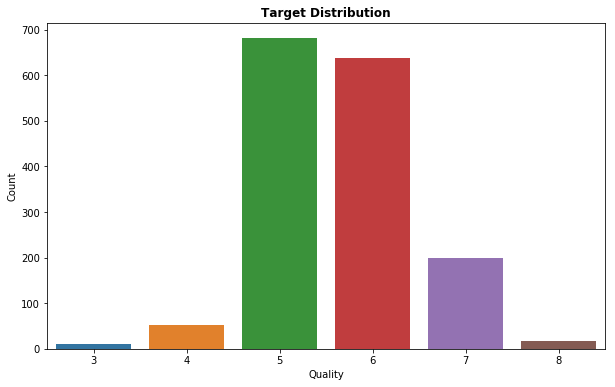

In [282]:
# Plot target class distribution
target_fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x='quality', data=df, ax=ax)
ax.set_ylabel('Count')
ax.set_xlabel('Quality')
ax.set_title('Target Distribution', fontweight='bold')

In [283]:
target_fig.savefig('./images/TargetDistribution.svg')

Text(0.5,1,'Feature Correlation')

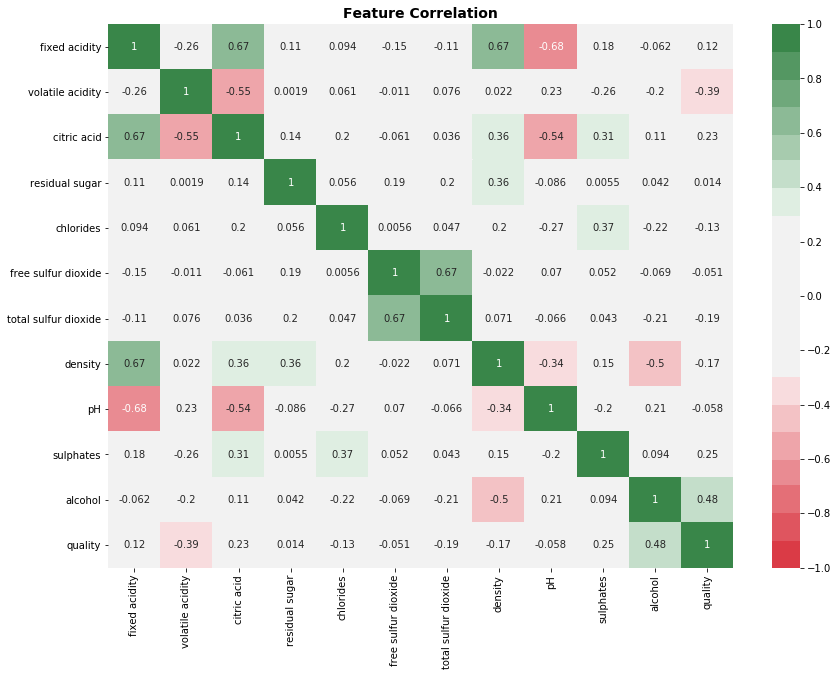

In [190]:
# Plot feature correlations
corr = df.corr()

corr_fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(corr, ax=ax, 
            center=0, vmin=-1, vmax=1, 
            cbar_kws={'ticks': np.arange(-1, 1.2, 0.2)},
            cmap=sns.diverging_palette(10, 133, sep=80, n=20), 
            annot=True)

ax.set_title('Feature Correlation', fontdict={'size': 14, 'weight': 'bold'})

In [191]:
corr_fig.savefig('./images/FeatureCorrelation.svg')

Text(0.5,0.98,'Feature Distributions')

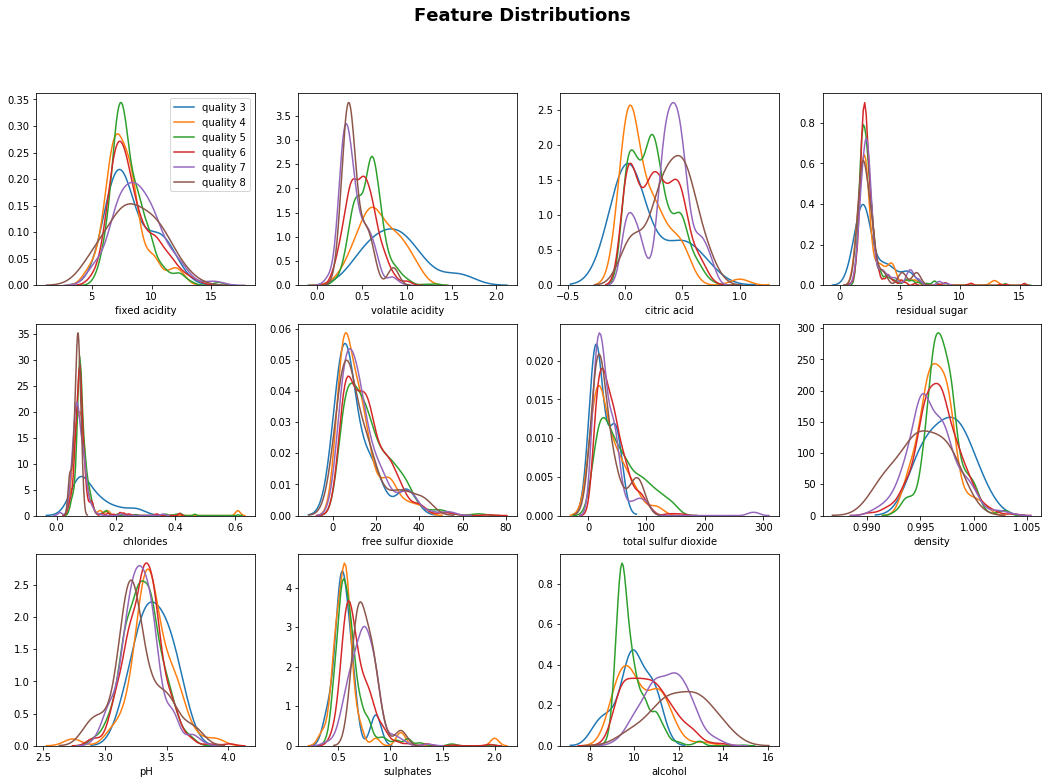

In [279]:
kde_fig, axes = plt.subplots(3, 4, figsize=(18, 12))
axes = axes.flatten()

axes[-1].remove()
cnt = 0
for ax, col in zip(axes[:-1], df.columns[:-1]):
    cnt += 1
    for q in sorted(df.quality.unique()):
        label = ('quality %d' % q)
        
        ax = sns.distplot(df[col][df.quality == q], hist=False, label=label, ax=ax)
        if cnt != 1:
            ax.legend_.remove()
            
plt.suptitle('Feature Distributions', fontsize=18, fontweight='bold')            

In [281]:
kde_fig.savefig('./images/FeatureDistributions.svg')

## Remap Target Classes

In [7]:
df_remap = df.copy()
df_remap['quality2'] = pd.cut(df.quality, bins=3, labels=[1, 2, 3])
df_remap['quality2'] = df_remap['quality2'].astype(int)

In [8]:
df_remap['quality2'].value_counts(sort=False)

1      63
2    1319
3     217
Name: quality2, dtype: int64

In [9]:
df_remap.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality2
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,2
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,2
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,2
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,2


## Data Splitting

In [10]:
# Split 
y = df_remap.quality2
X = df_remap.drop(columns=['quality', 'quality2'])

# # Make sure intercept exists
# if ~any(X.columns == 'Intercept'):
#     X.insert(0, 'Intercept', 1)
# else: 
#     X.Intercept = 1
    
# Stratified Split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, 
                     stratify=y, test_size=.5, random_state=129)

## Data Resampling

In [11]:
def resample_df(df, target_col, n_samples=None, replace=True):
    
    levels = df[target_col].unique()
    cnts = df[target_col].value_counts()
    
    if n_samples is None:
        n_samples = np.max(cnts)
    elif n_samples == 'max':
        n_samples = np.max(cnts)
    elif n_samples == 'min':
        n_samples = np.min(cnts)    
    elif n_samples == 'med':
        n_samples = np.median(cnts)
        
    df_resampled = pd.DataFrame()    
    for target_class in df[target_col].unique():
        
        df_target_class = df[df[target_col] == target_class]
        df_target_resampled = resample(df_target_class, 
                                       replace=replace,
                                       n_samples=n_samples,
                                       random_state=129)
        df_resampled = pd.concat([df_resampled, df_target_resampled], axis=0)
        
    return df_resampled           

In [12]:
df_train_resampled = resample_df(pd.concat([X_train, y_train], axis=1) , 'quality2', n_samples='max')
X_train = df_train_resampled.drop(columns='quality2')
y_train = df_train_resampled['quality2']

In [13]:
df_test_resampled = resample_df(pd.concat([X_test, y_test], axis=1) , 'quality2', n_samples='max')
X_test = df_test_resampled.drop(columns='quality2')
y_test = df_test_resampled['quality2']

In [14]:
X_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
417,7.0,0.580,0.12,1.9,0.091,34.0,124.0,0.99560,3.44,0.48,10.5
122,7.3,0.695,0.00,2.5,0.075,3.0,13.0,0.99800,3.49,0.52,9.2
386,7.8,0.540,0.26,2.0,0.088,23.0,48.0,0.99810,3.41,0.74,9.2
1568,7.0,0.560,0.13,1.6,0.077,25.0,42.0,0.99629,3.34,0.59,9.2
1539,7.2,0.390,0.32,1.8,0.065,34.0,60.0,0.99714,3.46,0.78,9.9


In [15]:
df_train_resampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1977 entries, 417 to 855
Data columns (total 12 columns):
fixed acidity           1977 non-null float64
volatile acidity        1977 non-null float64
citric acid             1977 non-null float64
residual sugar          1977 non-null float64
chlorides               1977 non-null float64
free sulfur dioxide     1977 non-null float64
total sulfur dioxide    1977 non-null float64
density                 1977 non-null float64
pH                      1977 non-null float64
sulphates               1977 non-null float64
alcohol                 1977 non-null float64
quality2                1977 non-null int64
dtypes: float64(11), int64(1)
memory usage: 200.8 KB


In [16]:
X_test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
25,6.3,0.39,0.16,1.4,0.080,11.0,23.0,0.9955,3.34,0.56,9.3
338,12.4,0.49,0.58,3.0,0.103,28.0,99.0,1.0008,3.16,1.00,11.5
179,8.8,0.61,0.14,2.4,0.067,10.0,42.0,0.9969,3.19,0.59,9.5
1425,8.3,0.26,0.37,1.4,0.076,8.0,23.0,0.9974,3.26,0.70,9.6
93,7.7,0.49,0.26,1.9,0.062,9.0,31.0,0.9966,3.39,0.64,9.6


In [17]:
df_test_resampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1980 entries, 25 to 1299
Data columns (total 12 columns):
fixed acidity           1980 non-null float64
volatile acidity        1980 non-null float64
citric acid             1980 non-null float64
residual sugar          1980 non-null float64
chlorides               1980 non-null float64
free sulfur dioxide     1980 non-null float64
total sulfur dioxide    1980 non-null float64
density                 1980 non-null float64
pH                      1980 non-null float64
sulphates               1980 non-null float64
alcohol                 1980 non-null float64
quality2                1980 non-null int64
dtypes: float64(11), int64(1)
memory usage: 201.1 KB


In [18]:
df_test_resampled.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality2
25,6.3,0.39,0.16,1.4,0.080,11.0,23.0,0.9955,3.34,0.56,9.3,2
338,12.4,0.49,0.58,3.0,0.103,28.0,99.0,1.0008,3.16,1.00,11.5,2
179,8.8,0.61,0.14,2.4,0.067,10.0,42.0,0.9969,3.19,0.59,9.5,2
1425,8.3,0.26,0.37,1.4,0.076,8.0,23.0,0.9974,3.26,0.70,9.6,2
93,7.7,0.49,0.26,1.9,0.062,9.0,31.0,0.9966,3.39,0.64,9.6,2


## Helper Functions

In [19]:
def normalize_confusion_matrix(cm):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)
    cm[np.isnan(cm)] = 0.0
    
    #     cm = (cm - np.min(cm)) / (np.max(cm) - np.min(cm))
    
    return cm

In [20]:
def discrete_heatmap(cm, clf=None, ax=None):
        
    from sklearn.preprocessing import normalize
    import matplotlib.pyplot as plt
    import seaborn as sns    
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    
    Z = normalize_confusion_matrix(cm)

    # Generate heatmap
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ax = sns.heatmap(Z, ax=ax, cmap='RdYlGn', annot=True, cbar_ax=cax,
                     vmin=0, vmax=1, cbar_kws={'ticks': np.arange(0, 1.2, 0.2)})
    
    ## Format axes object
    #  Format X-axis label and ticks
    ax.set_xlabel('Predicted', fontdict={'size': 12})
    ax.xaxis.set_ticks_position('top') 
    ax.xaxis.set_label_position('top')
    ax.set_xticklabels(['Low', 'Mid', 'High'], minor=False)
    
    # Format Y-axis label
    ax.set_ylabel('Truth', fontdict={'size': 12})
    ax.set_yticklabels(['Low', 'Mid', 'High'], minor=False)
    
    # Format Title [Note: double newlines are to create space between Title 
    # and the X-axis label that was moved to the top]
    
    if clf is None:
        clf = ''
    else:
        clf += ': '
    title_str = '\n' + clf + 'Confusion Matrix' + '\n\n'
    
    ax.set_title(title_str, fontdict={'size': 14, 'weight': 'bold'})
    
    return ax

In [21]:
def interpolated_heatmap(cm, clf=None, cb=False, ax=None):
    
    import numpy as np
    from sklearn.preprocessing import normalize
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
#         ax.patch.set_visible(False)
    
    Z = normalize_confusion_matrix(cm)

    # Generate X, Y indices of confusion matrix
    n_classes = Z.shape[0]
    X, Y = np.meshgrid(np.arange(0, n_classes, 1), np.arange(n_classes-1, -1, -1))

    # Plot contours
    contours = ax.contourf(X, Y, Z, 25, cmap='RdYlGn', vmin=0, vmax=1)
    
    if cb:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        ax2 = plt.colorbar(contours, cax=cax, ax=ax, ticks=np.arange(0, 1.2, 0.2))
    
    ## Format X-axis label and ticks
    ax.set_xlabel('Predicted', fontdict={'size': 12})
    # Move ticks and label to top
    ax.xaxis.set_ticks_position('top') 
    ax.xaxis.set_label_position('top')
    # Hide major tick labels
    ax.set_xticklabels([], minor=False) 
    ax.set_xticks([0, 2], minor=False)
    # Define and label minor ticks
    ax.set_xticks([0.3, 1, 1.7], minor=True)
    ax.set_xticklabels(['Low', 'Mid', 'High'], minor=True)

    ## Format Y-axis label and ticks
    ax.set_ylabel('Truth', fontdict={'size': 12})
    # Hide major tick labels
    ax.set_yticklabels([], minor=False)    
    # Create and label minor ticks
    ax.set_yticks([0.3, 1, 1.7], minor=True)
    ax.set_yticks([0, 2], minor=False)
    ax.set_yticklabels(['High', 'Mid', 'Low'], minor=True)

    # Format Title [Note: double newlines are to create space between Title 
    # and the X-axis label that was moved to the top]
    if clf is None:
        clf = ''
    else:
        clf += ': '
    title_str = '\n' + clf + 'Interpolated Confusion Matrix' + '\n\n'
    
    ax.set_title(title_str, fontdict={'size': 14, 'weight': 'bold'})
    
    return ax

In [22]:
def plot_roc_curves(y_test, y_pred, clf=None, ax=None):

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    skplt.metrics.plot_roc_curve(y_test, y_pred, ax=ax)

    ax.set_xlabel('FPR', fontdict={'size': 12}) #, 'weight': 'bold'})
    ax.set_ylabel('TPR', fontdict={'size': 12}) #, 'weight': 'bold'})

    if clf is None:
        clf = ''
    else:
        clf += ': '
    title_str = '\n' + clf + 'ROC Curves' + '\n'
    
    ax.set_title(title_str, fontdict={'size': 14, 'weight': 'bold'})
    
    return ax

In [23]:
def plot_precision_recall_curves(y_test, y_pred, clf=None, ax=None):

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
        
    skplt.metrics.plot_precision_recall_curve(y_test, y_pred, ax=ax)
    
    ax.set_xlabel('Recall', fontdict={'size': 12}) #, 'weight': 'bold'})
    ax.set_ylabel('Precision', fontdict={'size': 12}) #, 'weight': 'bold'})

    if clf is None:
        clf = ''
    else:
        clf += ': '
    title_str = '\n' + clf + 'Precision-Recall Curves' + '\n'
    
    ax.set_title(title_str, fontdict={'size': 14, 'weight': 'bold'})
    ax.legend(loc='lower left')
    
    return ax

In [24]:
def error_distance_cost(y_true, y_pred):
    
    cm = confusion_matrix(y_true, y_pred)
    cm = normalize_confusion_matrix(cm)
    
    cost = np.zeros_like(cm)
    rows, cols = cm.shape
    for ridx in range(rows):
        for cidx in range(cols):
            cost[ridx, cidx] = np.abs(ridx-cidx) * cm[ridx, cidx]

    return np.around(-np.sum(cost), decimals=5)


## Build Models

### NB

In [25]:
nb1 = GaussianNB()
nb1.fit(X_train, y_train)

print(nb1)

nb1_pred = nb1.predict(X_test)
nb1_probas = nb1.predict_proba(X_test)

print(classification_report(y_test, nb1_pred))
print(confusion_matrix(y_test, nb1_pred))

GaussianNB(priors=None)
             precision    recall  f1-score   support

          1       0.71      0.53      0.60       660
          2       0.50      0.53      0.51       660
          3       0.63      0.75      0.69       660

avg / total       0.61      0.60      0.60      1980

[[347 229  84]
 [100 350 210]
 [ 41 121 498]]


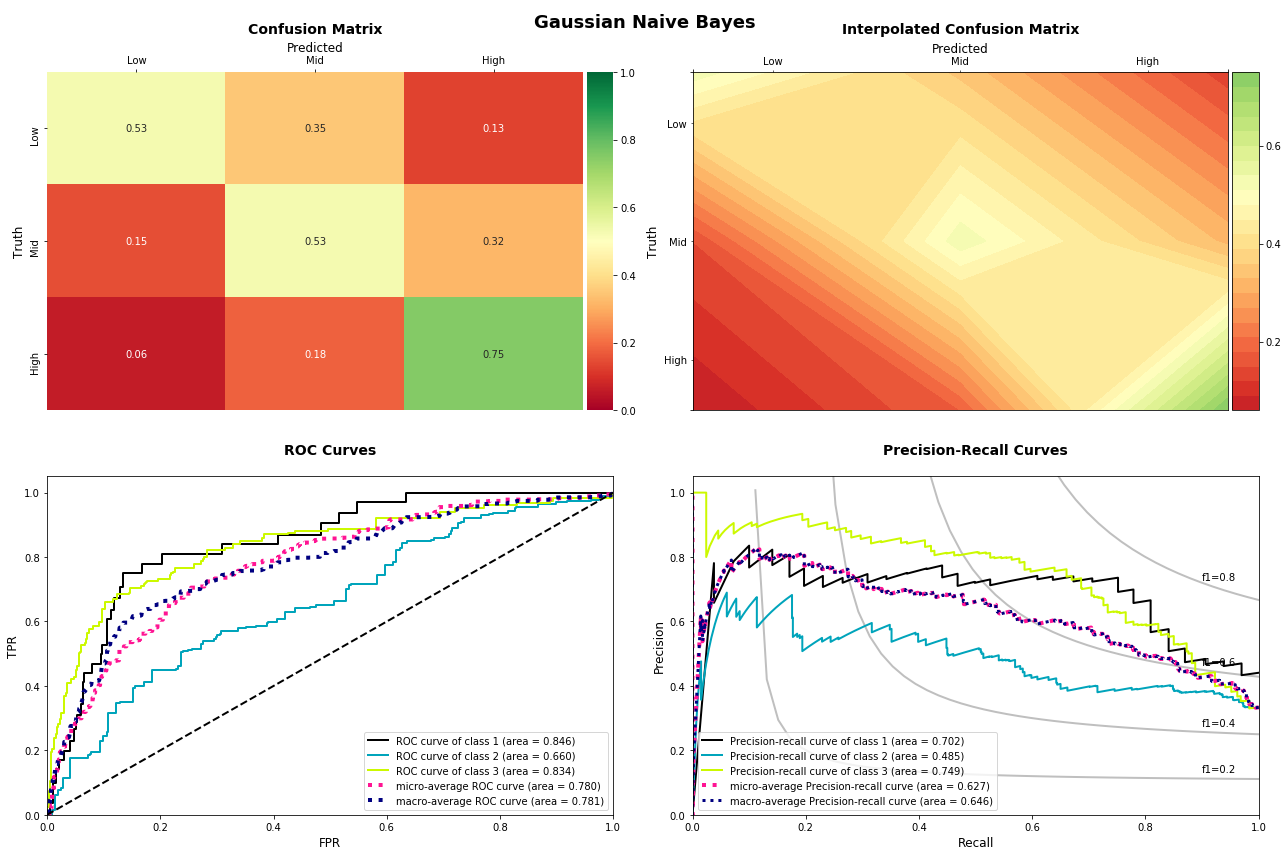

In [47]:
gnb_fig, axes = plt.subplots(2, 2, figsize=(18, 12))
ax0, ax1, ax2, ax3 = axes.flatten()

from mpl_toolkits.axes_grid1 import make_axes_locatable

hm_ax = discrete_heatmap(confusion_matrix(y_test, nb1_pred), ax=ax0)
ihm_ax = interpolated_heatmap(confusion_matrix(y_test, nb1_pred), cb=True, ax=ax1)
roc_ax = plot_roc_curves(y_test, nb1_probas, ax=ax2)
pr_ax = plot_precision_recall_curves(y_test, nb1_probas, ax=ax3)

plt.suptitle('Gaussian Naive Bayes', fontsize=18, fontweight='bold')
gnb_fig.tight_layout()

In [48]:
gnb_fig.savefig('GaussianNB.svg')

### SVM

In [81]:
svm0 = make_pipeline(StandardScaler(), SVC(C=0.001, 
                                           class_weight='balanced', 
                                           probability=True,
                                           random_state=129))

svm0.fit(X_train, y_train)

print(svm0)

svm0_pred = svm0.predict(X_test)
svm0_probas = svm0.predict_proba(X_test)

print(classification_report(y_test, svm0_pred))
print(confusion_matrix(y_test, svm0_pred))

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=0.001, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=129, shrinking=True,
  tol=0.001, verbose=False))])
             precision    recall  f1-score   support

          1       0.66      0.75      0.70       660
          2       0.56      0.52      0.54       660
          3       0.76      0.71      0.73       660

avg / total       0.66      0.66      0.66      1980

[[497 163   0]
 [169 344 147]
 [ 87 107 466]]


#### Pickle SVM Model

#### Create Multi-Axes SVM Plot

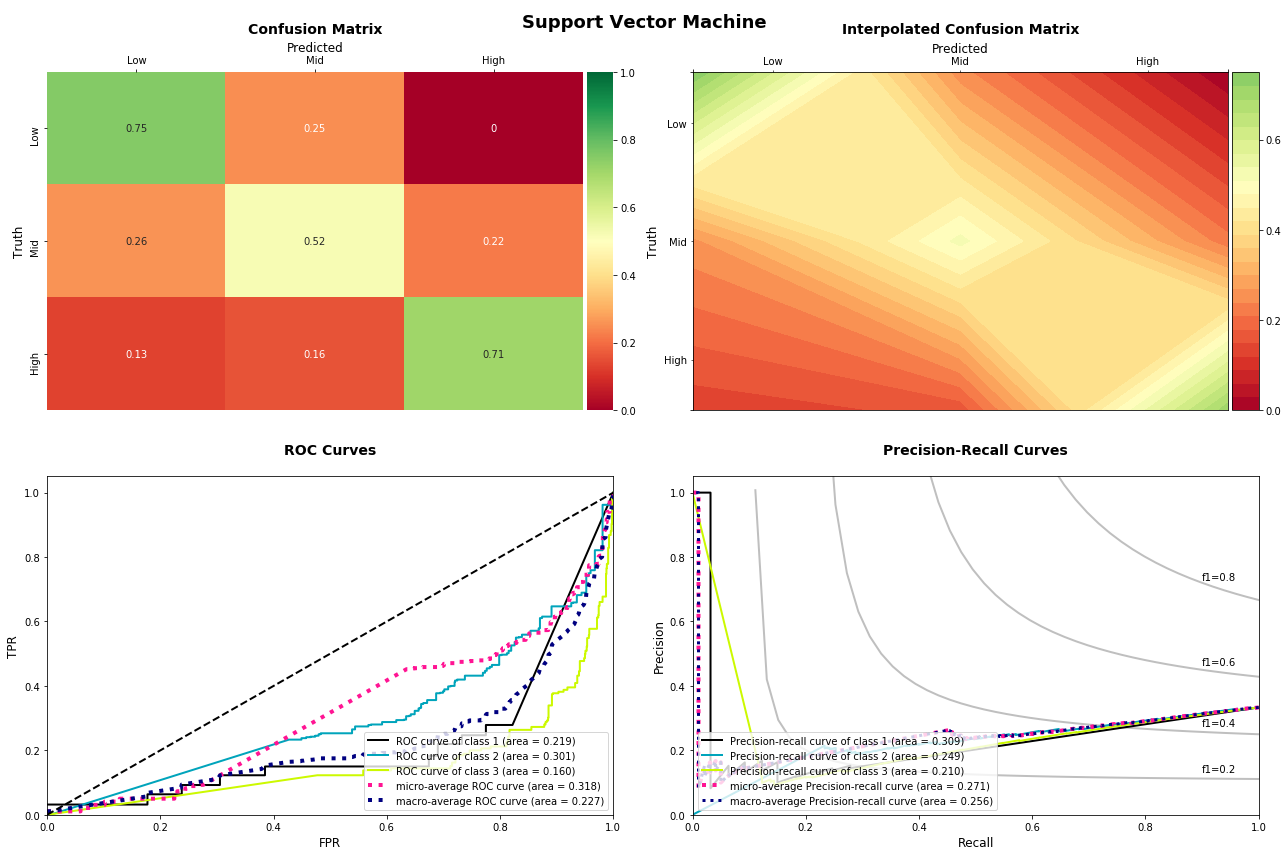

In [83]:
svm0_fig, axes = plt.subplots(2, 2, figsize=(18, 12))
ax0, ax1, ax2, ax3 = axes.flatten()

hm_ax = discrete_heatmap(confusion_matrix(y_test, svm0_pred), ax=ax0)
ihm_ax = interpolated_heatmap(confusion_matrix(y_test, svm0_pred), cb=True, ax=ax1)
roc_ax = plot_roc_curves(y_test, svm0_probas, ax=ax2)
pr_ax = plot_precision_recall_curves(y_test, svm0_probas, ax=ax3)

plt.suptitle('Support Vector Machine', fontsize=18, fontweight='bold')
svm0_fig.tight_layout()

In [92]:
svm1 = make_pipeline(StandardScaler(), SVC(C=0.01, 
                                           class_weight='balanced', 
                                           probability=True, 
                                           random_state=129))

svm1.fit(X_train, y_train)

print(svm1)

svm1_pred = svm1.predict(X_test)
svm1_probas = svm1.predict_proba(X_test)

print(classification_report(y_test, svm1_pred))
print(confusion_matrix(y_test, svm1_pred))

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=0.01, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=129, shrinking=True,
  tol=0.001, verbose=False))])
             precision    recall  f1-score   support

          1       0.67      0.75      0.71       660
          2       0.54      0.53      0.53       660
          3       0.75      0.67      0.71       660

avg / total       0.65      0.65      0.65      1980

[[497 163   0]
 [161 349 150]
 [ 80 138 442]]


In [93]:
# Pickle
pickle.dump(svm1, open("svm_model.pkl", "wb"))

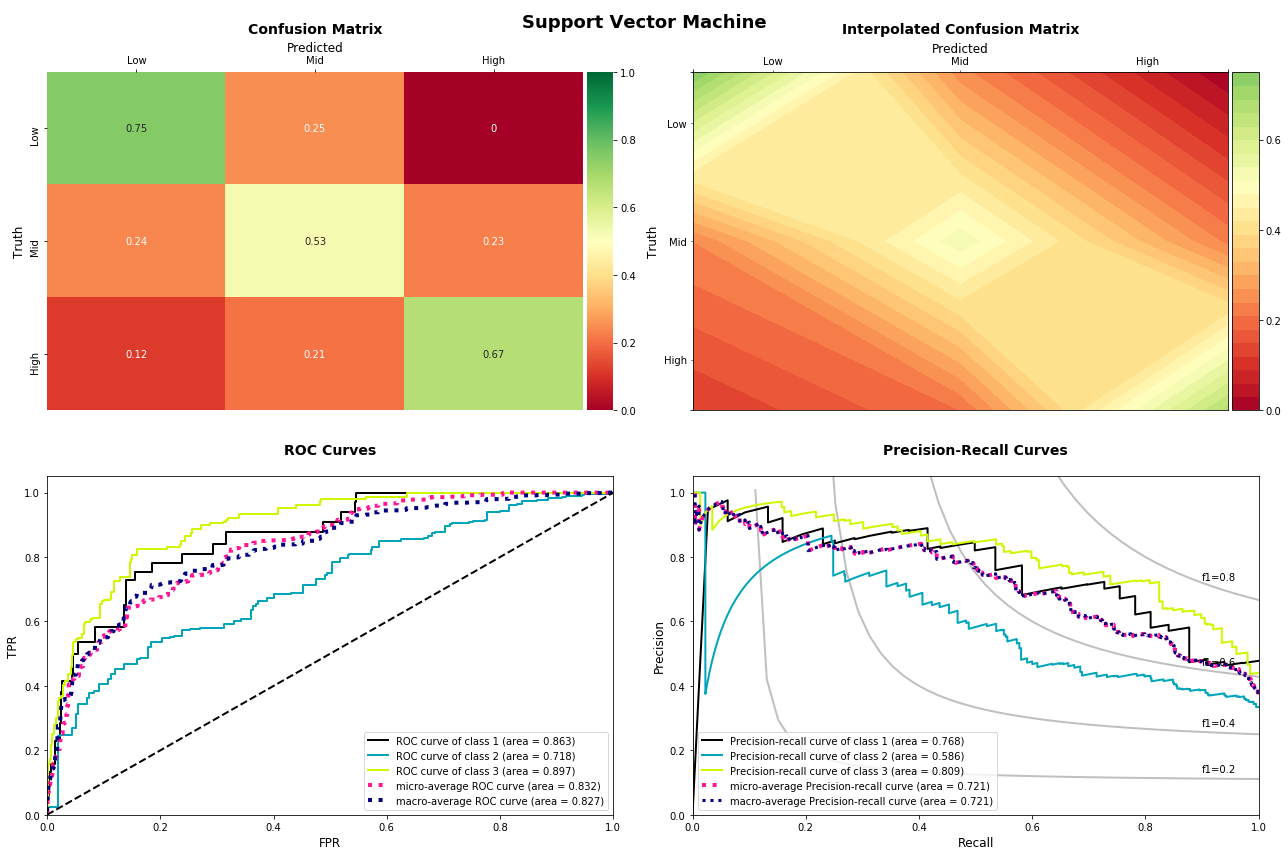

In [94]:
svm1_fig, axes = plt.subplots(2, 2, figsize=(18, 12))
ax0, ax1, ax2, ax3 = axes.flatten()

hm_ax = discrete_heatmap(confusion_matrix(y_test, svm1_pred), ax=ax0)
ihm_ax = interpolated_heatmap(confusion_matrix(y_test, svm1_pred), cb=True, ax=ax1)
roc_ax = plot_roc_curves(y_test, svm1_probas, ax=ax2)
pr_ax = plot_precision_recall_curves(y_test, svm1_probas, ax=ax3)

plt.suptitle('Support Vector Machine', fontsize=18, fontweight='bold')
svm1_fig.tight_layout()

In [102]:
svm1_fig.savefig('SVM.svg')

In [32]:
# svm2 = make_pipeline(StandardScaler(), 
#                      GridSearchCV(SVC(class_weight='balanced', probability=True, random_state=129),
#                                   scoring='fowlkes_mallows_score', #make_scorer(error_distance_cost), 
#                                   refit=True,
#                                   param_grid={'C': [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]},
#                                   cv=5, return_train_score=True))
# print(svm2)

# svm2.fit(X_train, y_train)

# svm2_pred = svm2.predict(X_test)
# svm2_probas = svm2.predict_proba(X_test)

# print(classification_report(y_test, svm2_pred))
# print(confusion_matrix(y_test, svm2_pred))

In [33]:
# svm2.named_steps['gridsearchcv'].cv_results_

In [34]:
# svm2.named_steps['gridsearchcv'].best_estimator_

### KNN

In [97]:
knn1 = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=250))

knn1.fit(X_train, y_train)

print(knn1)

knn1_pred = knn1.predict(X_test)
knn1_probas = knn1.predict_proba(X_test)

print(classification_report(y_test, knn1_pred))
print(confusion_matrix(y_test, knn1_pred))

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kneighborsclassifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=250, p=2,
           weights='uniform'))])
             precision    recall  f1-score   support

          1       0.73      0.70      0.72       660
          2       0.53      0.55      0.54       660
          3       0.74      0.74      0.74       660

avg / total       0.67      0.66      0.67      1980

[[464 196   0]
 [124 363 173]
 [ 47 125 488]]


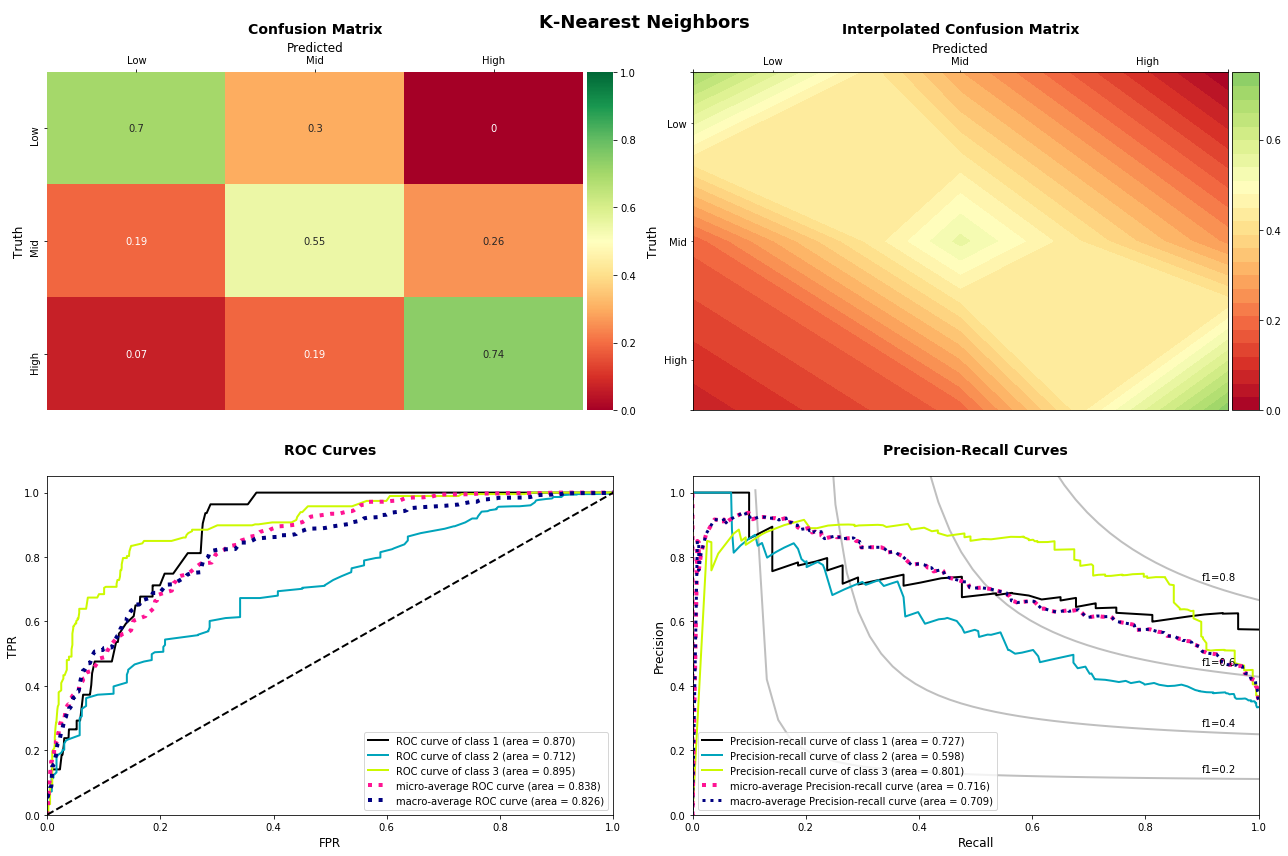

In [100]:
knn_fig, axes = plt.subplots(2, 2, figsize=(18, 12))
ax0, ax1, ax2, ax3 = axes.flatten()

hm_ax = discrete_heatmap(confusion_matrix(y_test, knn1_pred), ax=ax0)
ihm_ax = interpolated_heatmap(confusion_matrix(y_test, knn1_pred), cb=True, ax=ax1)
roc_ax = plot_roc_curves(y_test, knn1_probas, ax=ax2)
pr_ax = plot_precision_recall_curves(y_test, knn1_probas, ax=ax3)

plt.suptitle('K-Nearest Neighbors', fontsize=18, fontweight='bold')
knn_fig.tight_layout()

In [101]:
knn_fig.savefig('KNN.svg')

In [37]:
knn2 = make_pipeline(StandardScaler(), 
                     GridSearchCV(KNeighborsClassifier(),
                                  param_grid={'n_neighbors': np.arange(5, 605, 10)},
                                  scoring='accuracy',
                                  cv=3, return_train_score=True,
                                  refit=True))
print(knn2)

knn2.fit(X_train, y_train)

knn2_pred = knn2.predict(X_test)
knn2_probas = knn2.predict_proba(X_test)

print(classification_report(y_test, knn2_pred))
print(confusion_matrix(y_test, knn2_pred))

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gridsearchcv', GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
       ...re_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0))])
             precision    recall  f1-score   support

          1       0.67      0.22      0.33       660
          2       0.42      0.63      0.50       660
          3       0.64      0.74      0.69       660

avg / total       0.58      0.53      0.51      1980

[[147 429  84]
 [ 53 419 188]
 [ 19 152 489]]


### Logistic Regression

In [38]:
lr3 = LogisticRegression(C=1e3, 
                         class_weight='balanced', 
                         random_state=129,
                         multi_class='multinomial',
                         solver='newton-cg', max_iter=1000)
lr3.fit(X_train, y_train)

print(lr3)

# make predictions
lr3_pred = lr3.predict(X_test)
lr3_probas = lr3.predict_proba(X_test)

# summarize the fit of the model
print(classification_report(y_test, lr3_pred))
print(confusion_matrix(y_test, lr3_pred))

LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=129, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)
             precision    recall  f1-score   support

          1       0.72      0.75      0.74       660
          2       0.61      0.52      0.56       660
          3       0.76      0.84      0.80       660

avg / total       0.70      0.70      0.70      1980

[[495 145  20]
 [159 341 160]
 [ 30  75 555]]


In [103]:
pipe3 = make_pipeline(StandardScaler(), lr3)

pipe3.fit(X_train, y_train)

print(pipe3)

# make predictions
pipe3_pred = pipe3.predict(X_test)
pipe3_probas = pipe3.predict_proba(X_test)
pipe3_conf = pipe3.decision_function(X_test)

# summarize the fit of the model
print(classification_report(y_test, pipe3_pred))
print(confusion_matrix(y_test, pipe3_pred))

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=129, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False))])
             precision    recall  f1-score   support

          1       0.75      0.72      0.74       660
          2       0.60      0.56      0.58       660
          3       0.76      0.84      0.80       660

avg / total       0.70      0.71      0.70      1980

[[474 166  20]
 [136 371 153]
 [ 18  86 556]]


#### Pickle Logisitic Model

In [104]:
pickle.dump(pipe3, open("logistic_model.pkl", "wb"))

#### Create Multi-Axes Logistic Plot

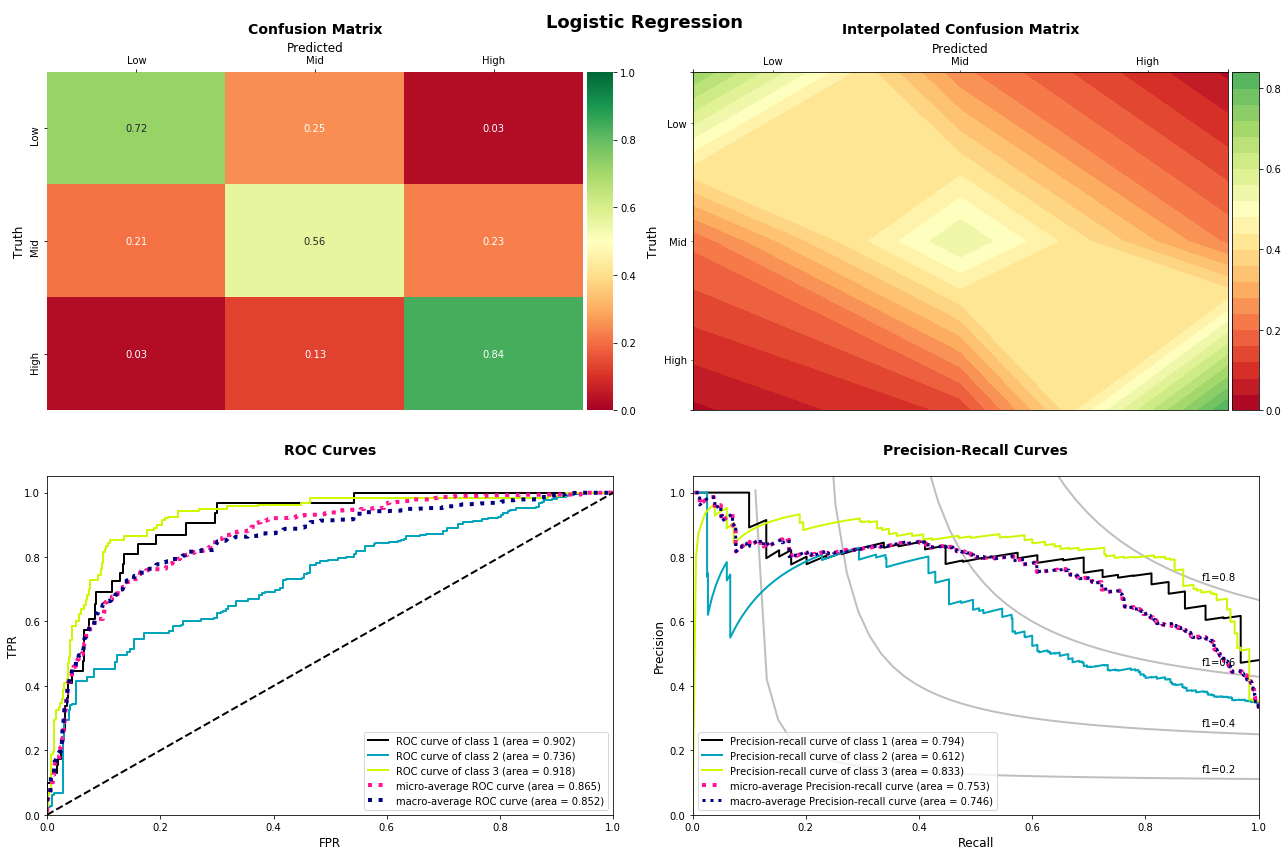

In [105]:
lr_fig, axes = plt.subplots(2, 2, figsize=(18, 12))
ax0, ax1, ax2, ax3 = axes.flatten()

from mpl_toolkits.axes_grid1 import make_axes_locatable

hm_ax = discrete_heatmap(confusion_matrix(y_test, pipe3_pred), ax=ax0)
ihm_ax = interpolated_heatmap(confusion_matrix(y_test, pipe3_pred), cb=True, ax=ax1)
roc_ax = plot_roc_curves(y_test, pipe3_probas, ax=ax2)
pr_ax = plot_precision_recall_curves(y_test, pipe3_probas, ax=ax3)

plt.suptitle('Logistic Regression', fontsize=18, fontweight='bold')
lr_fig.tight_layout()

In [106]:
lr_fig.savefig('Logistic.svg')

#### Create Large Logistic Plots for Slides

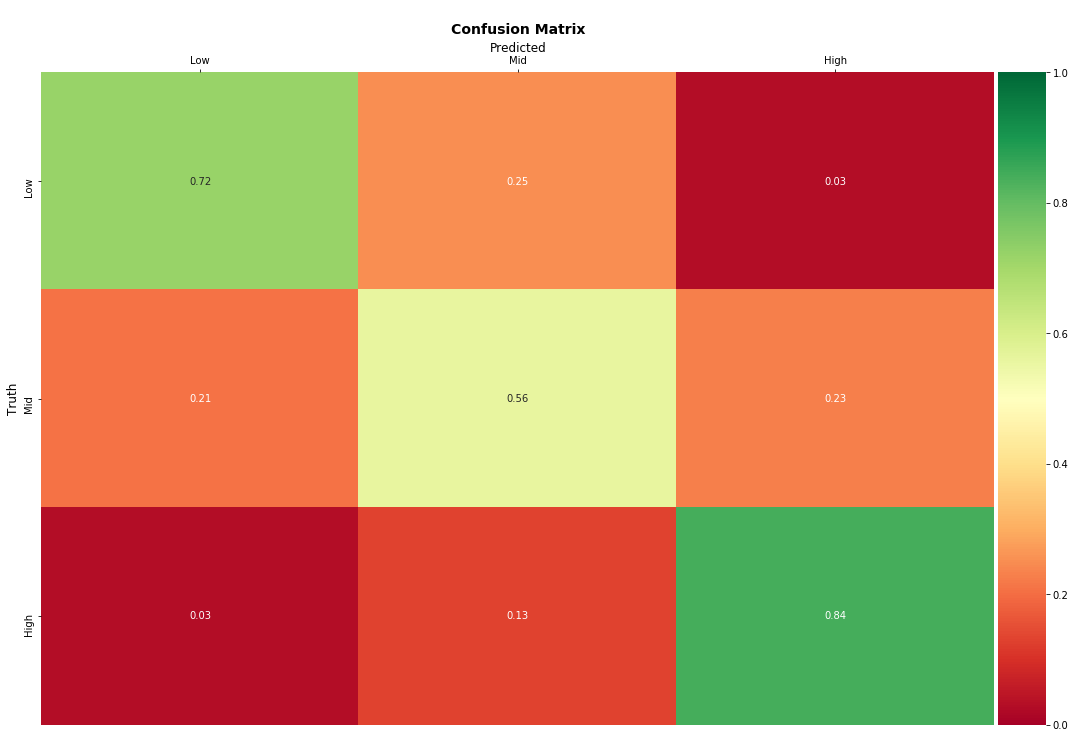

In [42]:
fig, axes = plt.subplots(figsize=(18, 12))
discrete_heatmap(confusion_matrix(y_test, pipe3_pred), ax=axes)

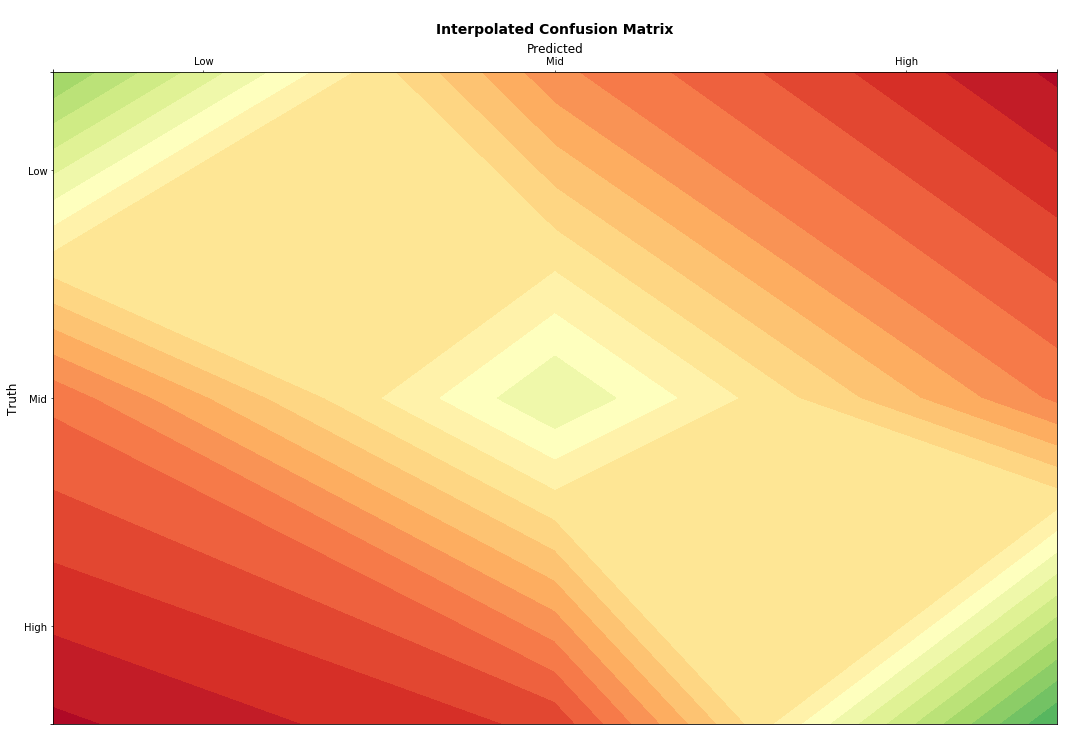

In [43]:
fig, axes = plt.subplots(figsize=(18, 12))
interpolated_heatmap(confusion_matrix(y_test, pipe3_pred), cb=False, ax=axes)

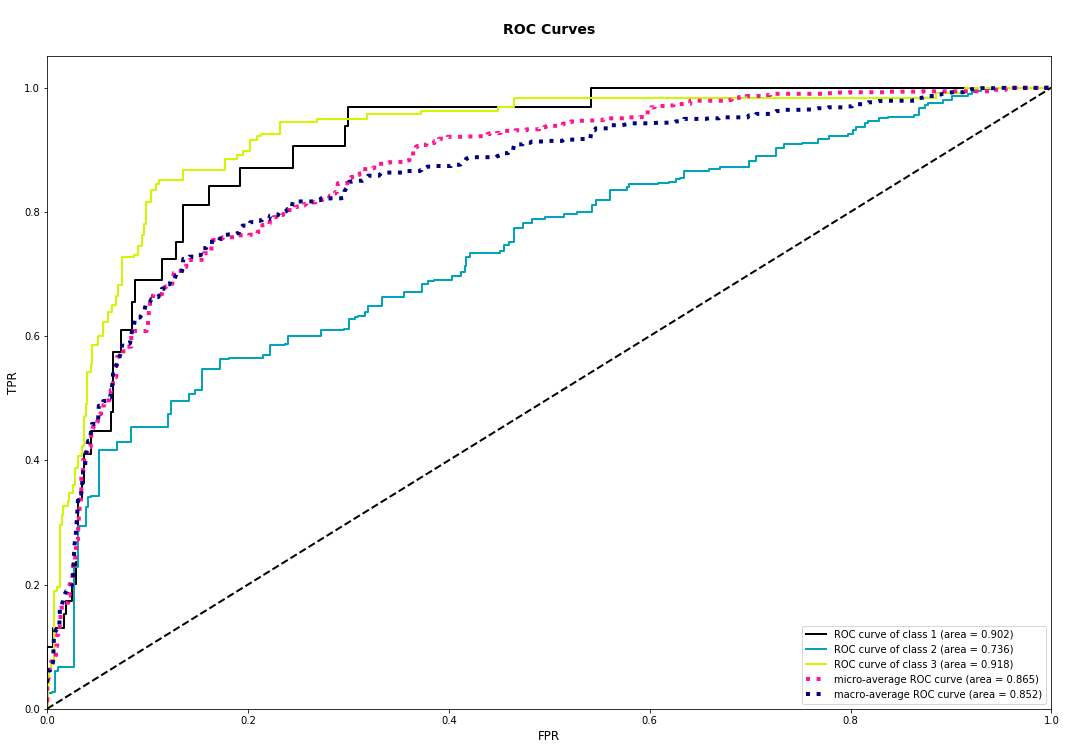

In [44]:
fig, axes = plt.subplots(figsize=(18, 12))
roc_ax = plot_roc_curves(y_test, pipe3_probas, ax=axes)

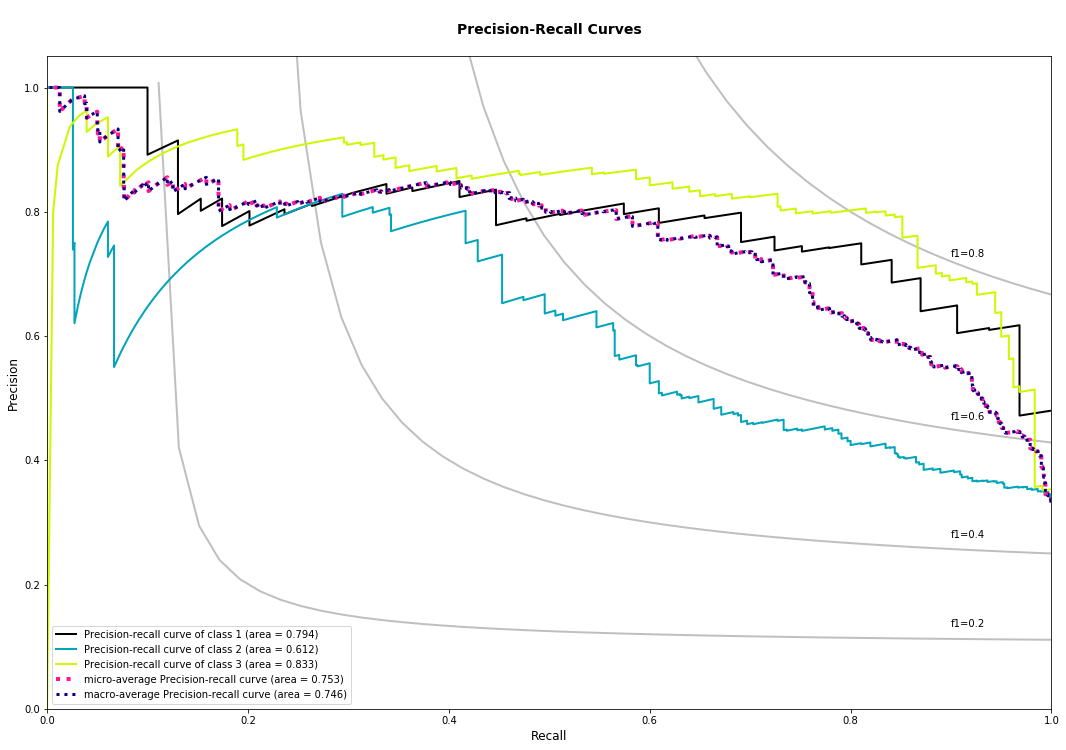

In [45]:
fig, axes = plt.subplots(figsize=(18, 12))
pr_ax = plot_precision_recall_curves(y_test, pipe3_probas, ax=axes)

### Plot Decision Boundaries